# Continual Learning Experiment 
-----------------------------
### WARNING : This is NOT our benchmark. This is a proof of concept. For our benchmark on adversarial attacks, please refer to benchmark.ipynb

In [2]:
%load_ext autoreload
%autoreload 2
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

#### Loading Modules

In [86]:
import torch
from src.utils import dataset
from matplotlib import pyplot as plt
from src.continual_learning.CertifiedPostTrainer import CertifiedPostTrainer
from src.optimizers import interval_narrowers
from src.optimizers.ConstrainedVolumeMultiphaseTrainer import ConstrainedVolumeMultiphaseTrainer
from src.optimizers.HypercubeTrainer import HypercubeTrainer
from src.utils.evaluation import evaluate_accuracy
from src.cert import Safebox
from torch.utils.data import DataLoader, Dataset
from src.bayes.BayesianModel import BayesianModel
from src.optimizers.SAMTrainer import SAMTrainer
from src.optimizers.SimpleTrainer import SimpleTrainer
import scienceplots
import numpy as np
from matplotlib.lines import Line2D

#### Utils and Constants

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
def display_dataset(dataset):
    fig, axs = plt.subplots(1,10)
    fig.set_figwidth(15)
    for i in range(10):
        axs[i].set_axis_off()
        axs[i].imshow(dataset[i][0].numpy().reshape((28,28)), cmap="gray")

In [6]:
def get_model(output_dim=10):
    """Returns a simple CNN model."""
    model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(8, 1, kernel_size=5, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(576, output_dim),
    ).to(DEVICE)
    return model

def certify_accuracy(dataset: Dataset, bound_model: torch.nn.Sequential, device="cpu") -> float:
    X, y = next(iter(DataLoader(dataset, batch_size=len(dataset), shuffle=True)))
    X, y, = X.to(device), y.to(device)
    bound_model.eval()
    with torch.no_grad():
        return Safebox.min_acc(y, bound_model(X.unsqueeze(-1).expand(*X.shape, 2))).item()


In [17]:
plt.style.use(['science','ieee'])

### MNIST Experiment
---------
In this setup we learn first to classify between digits 0 and 1 and then learn to classify between digits 6 and 7 using the same network. We do not have access to the previous dataset when doing finetuning.

Digit 01 Train Dataset Size:  10132
Digit 01 Test Dataset Size:  2533
Digit 01 Validation Dataset Size:  2115
Digit 67 Train Dataset Size:  9746
Digit 67 Test Dataset Size:  2437
Digit 67 Validation Dataset Size:  1986


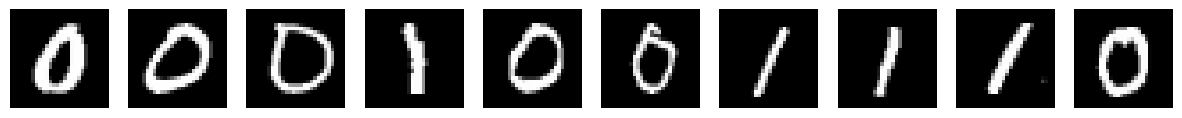

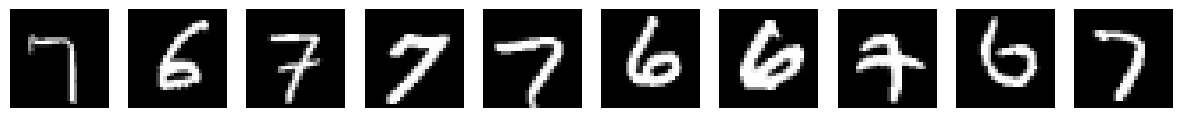

In [8]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

mnist_train_test, mnist_val = dataset.get_mnist_dataset(root="./data")
digit_01_train_test, digit01_val = dataset.filter_labels(mnist_train_test, [0,1]), dataset.filter_labels(mnist_val, [0,1])
digit67_train_test, digit67_val = dataset.filter_labels(mnist_train_test, [6,7]), dataset.filter_labels(mnist_val, [6,7])

digit01_train, digit01_test = dataset.split_dataset(digit_01_train_test, split_proportion=0.8)
digit67_train, digit67_test = dataset.split_dataset(digit67_train_test, split_proportion=0.8)
digit67_train = dataset.map_labels(digit67_train, {6:0, 7:1})
digit67_val = dataset.map_labels(digit67_val, {6:0, 7:1})
digit67_test = dataset.map_labels(digit67_test, {6:0, 7:1})
print("Digit 01 Train Dataset Size: ", len(digit01_train))
print("Digit 01 Test Dataset Size: ", len(digit01_test))
print("Digit 01 Validation Dataset Size: ", len(digit01_val))
display_dataset(digit01_train)
print("Digit 67 Train Dataset Size: ", len(digit67_train))
print("Digit 67 Test Dataset Size: ", len(digit67_test))
print("Digit 67 Validation Dataset Size: ", len(digit67_val))
display_dataset(digit67_train)

In [21]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

h_model_mnist = get_model(output_dim=2)
optimizer_mnist = HypercubeTrainer(h_model_mnist, device=DEVICE)
multiphase_trainer_mnist = ConstrainedVolumeMultiphaseTrainer(
    optimizer_mnist, 
    inflate_function=interval_narrowers.inflate_multiplier(1.5),
    narrow_function=interval_narrowers.narrower_halver(0.5),
    starting_value=1e-4*0.5, 
    min_acc_limit=0.78,
    quiet=False
)
multiphase_trainer_mnist.train(
    16, digit01_val,
    digit01_train, digit01_val, loss_obj=0.0, max_iters=500, batch_size=64, lr=1e-3,
    n_iter_eval_stop = 1000000,
              hard_min_loss_stop = 2.2
)

========== Started Multiphase Trainer for 16 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


100%|██████████| 500/500 [00:18<00:00, 27.74it/s, loss=0.0002, min_val_acc=0.999]


=> Initial center accuracy is 0.9990543723106384
-> Starting phase 15
-> Current Volume interval : [5e-05, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 38.54it/s, loss=0.0015, min_val_acc=1]    


-> Phase done
-> Center Accuracy is 0.9995272159576416.
-> Generalization is above minimum accuracy by 0.21952721595764157.!
-> Starting phase 15
-> Current Volume interval : [7.5e-05, INFINITY]


100%|██████████| 500/500 [00:13<00:00, 38.10it/s, loss=0, min_val_acc=1]         


-> Phase done
-> Center Accuracy is 0.9995272159576416.
-> Generalization is above minimum accuracy by 0.21952721595764157.!
-> Starting phase 15
-> Current Volume interval : [0.0001125, INFINITY]


100%|██████████| 500/500 [00:13<00:00, 37.66it/s, loss=0, min_val_acc=1]         


-> Phase done
-> Center Accuracy is 0.9995272159576416.
-> Generalization is above minimum accuracy by 0.21952721595764157.!
-> Starting phase 15
-> Current Volume interval : [0.00016875, INFINITY]


100%|██████████| 500/500 [00:13<00:00, 37.43it/s, loss=0, min_val_acc=0.999]     


-> Phase done
-> Center Accuracy is 0.9995272159576416.
-> Generalization is above minimum accuracy by 0.21952721595764157.!
-> Starting phase 15
-> Current Volume interval : [0.00025312, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 38.85it/s, loss=0, min_val_acc=0.999]     


-> Phase done
-> Center Accuracy is 0.99858158826828.
-> Generalization is above minimum accuracy by 0.21858158826828.!
-> Starting phase 15
-> Current Volume interval : [0.00037969, INFINITY]


100%|██████████| 500/500 [00:13<00:00, 38.12it/s, loss=0, min_val_acc=0.997]     


-> Phase done
-> Center Accuracy is 0.9976359605789185.
-> Generalization is above minimum accuracy by 0.21763596057891843.!
-> Starting phase 15
-> Current Volume interval : [0.00056953, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 38.86it/s, loss=0, min_val_acc=0.999]     


-> Phase done
-> Center Accuracy is 0.9995272159576416.
-> Generalization is above minimum accuracy by 0.21952721595764157.!
-> Starting phase 15
-> Current Volume interval : [0.0008543, INFINITY]


100%|██████████| 500/500 [00:13<00:00, 38.05it/s, loss=0, min_val_acc=0.998]     


-> Phase done
-> Center Accuracy is 0.9990543723106384.
-> Generalization is above minimum accuracy by 0.2190543723106384.!
-> Starting phase 15
-> Current Volume interval : [0.00128145, INFINITY]


100%|██████████| 500/500 [00:13<00:00, 36.78it/s, loss=0, min_val_acc=0.999]     


-> Phase done
-> Center Accuracy is 0.9990543723106384.
-> Generalization is above minimum accuracy by 0.2190543723106384.!
-> Starting phase 15
-> Current Volume interval : [0.00192217, INFINITY]


100%|██████████| 500/500 [00:13<00:00, 36.24it/s, loss=0, min_val_acc=0.998]     


-> Phase done
-> Center Accuracy is 0.9990543723106384.
-> Generalization is above minimum accuracy by 0.2190543723106384.!
-> Starting phase 15
-> Current Volume interval : [0.00288325, INFINITY]


100%|██████████| 500/500 [00:13<00:00, 37.18it/s, loss=0, min_val_acc=0.996]     


-> Phase done
-> Center Accuracy is 0.9995272159576416.
-> Generalization is above minimum accuracy by 0.21952721595764157.!
-> Starting phase 15
-> Current Volume interval : [0.00432488, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 38.74it/s, loss=0, min_val_acc=0.996]     


-> Phase done
-> Center Accuracy is 1.0.
-> Generalization is above minimum accuracy by 0.21999999999999997.!
-> Starting phase 15
-> Current Volume interval : [0.00648732, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 39.45it/s, loss=0, min_val_acc=0.995]     


-> Phase done
-> Center Accuracy is 0.9995272159576416.
-> Generalization is above minimum accuracy by 0.21952721595764157.!
-> Starting phase 15
-> Current Volume interval : [0.00973098, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 38.94it/s, loss=0, min_val_acc=0.991]     


-> Phase done
-> Center Accuracy is 1.0.
-> Generalization is above minimum accuracy by 0.21999999999999997.!
-> Starting phase 15
-> Current Volume interval : [0.01459646, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 39.67it/s, loss=0.14, min_val_acc=0.984]  


-> Phase done
-> Center Accuracy is 1.0.
-> Generalization is above minimum accuracy by 0.21999999999999997.!
Training succeeded !


True

In [22]:
bound_model_mnist = multiphase_trainer_mnist.result()
center_model_mnist = Safebox.bmodelToModel(bound_model_mnist).to(DEVICE)

certified_accuracy_originial_task = certify_accuracy(digit01_test, bound_model_mnist, device=DEVICE)
initial_accuracy_new_task = evaluate_accuracy(digit67_test, center_model_mnist, num_samples=len(digit67_test), device=DEVICE)

print(f"Certified Accuracy of bound model on original task {certified_accuracy_originial_task}")
print(f"Initial center model accuracy on new task {initial_accuracy_new_task}")
post_trainer_mnist = CertifiedPostTrainer(bound_model_mnist, device=DEVICE)

post_trainer_mnist.train(
    digit67_train,
    digit67_val, loss_obj=0.0, max_iters=700, batch_size=64, lr=1e-3,
    n_iter_eval_stop = 10000000000,
)
fine_tuned_model_mnist = post_trainer_mnist.result()

fine_tuned_accuracy_new_task = evaluate_accuracy(digit67_test, fine_tuned_model_mnist, num_samples=len(digit67_test), device=DEVICE)
fine_tuned_accuracy_original_task = evaluate_accuracy(digit01_test, fine_tuned_model_mnist, num_samples=len(digit01_test), device=DEVICE)
print(f"Final Fine-Tuned model accuracy on new task {fine_tuned_accuracy_new_task}")
print(f"Final Fine-Tuned model accuracy on original task {fine_tuned_accuracy_original_task}")

Certified Accuracy of bound model on original task 0.976707398891449
Initial center model accuracy on new task 0.7086581587791443


100%|██████████| 700/700 [00:10<00:00, 69.35it/s, loss=3.93, val_acc=0.824] 


Final Fine-Tuned model accuracy on new task 0.7890849113464355
Final Fine-Tuned model accuracy on original task 0.9992104172706604


item 01 Train Dataset Size:  9600
item 01 Test Dataset Size:  2400
item 01 Validation Dataset Size:  2000
item 23 Train Dataset Size:  9600
item 23 Test Dataset Size:  2400
item 23 Validation Dataset Size:  2000


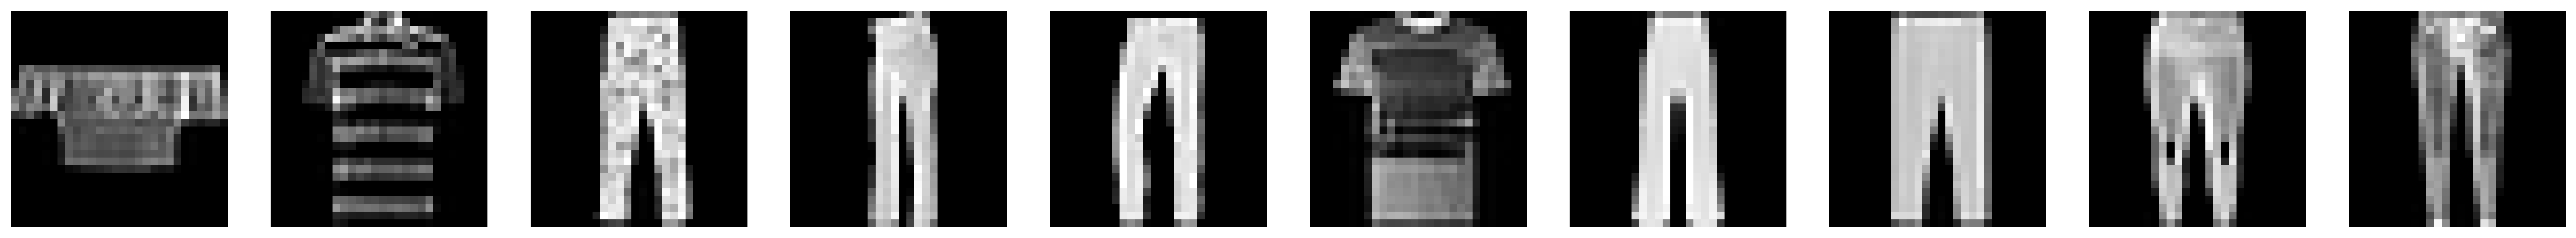

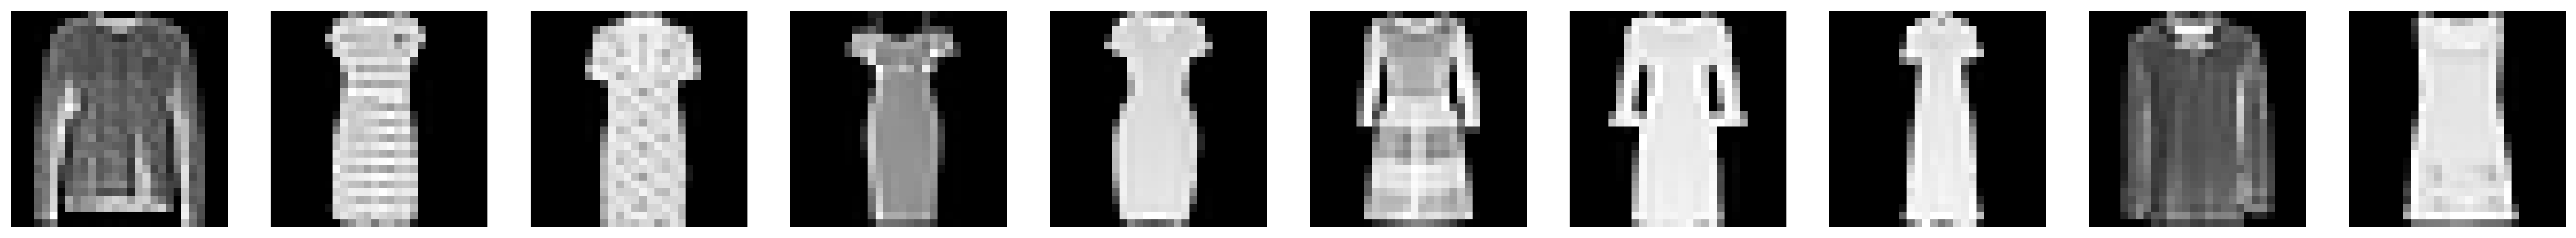

In [64]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

fashion_mnist_train_test, fashion_mnist_val = dataset.get_fashion_mnist_dataset(root="./data")
item_01_train_test, item01_val = dataset.filter_labels(fashion_mnist_train_test, [0,1]), dataset.filter_labels(fashion_mnist_val, [0,1])
item_23_train_test, item23_val = dataset.filter_labels(fashion_mnist_train_test, [2,3]), dataset.filter_labels(fashion_mnist_val, [2,3])

item01_train, item01_test = dataset.split_dataset(item_01_train_test, split_proportion=0.8)
item23_train, item23_test = dataset.split_dataset(item_23_train_test, split_proportion=0.8)
item23_train = dataset.map_labels(item23_train, {2:0, 3:1})
item23_val = dataset.map_labels(item23_val, {2:0, 3:1})
item23_test = dataset.map_labels(item23_test, {2:0, 3:1})
print("item 01 Train Dataset Size: ", len(item01_train))
print("item 01 Test Dataset Size: ", len(item01_test))
print("item 01 Validation Dataset Size: ", len(item01_val))
display_dataset(item01_train)
print("item 23 Train Dataset Size: ", len(item23_train))
print("item 23 Test Dataset Size: ", len(item23_test))
print("item 23 Validation Dataset Size: ", len(item23_val))
display_dataset(item23_train)

In [65]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

h_model_fashion = get_model(output_dim=2)
optimizer_fashion = HypercubeTrainer(h_model_fashion, device=DEVICE)
multiphase_trainer_fashion = ConstrainedVolumeMultiphaseTrainer(
    optimizer_fashion, 
    inflate_function=interval_narrowers.inflate_multiplier(1.5),
    narrow_function=interval_narrowers.narrower_halver(0.5),
    starting_value=1e-4*0.5, 
    min_acc_limit=0.78,
    quiet=False
)
multiphase_trainer_fashion.train(
    16, item01_val,
    item01_train, item01_val, loss_obj=0.0, max_iters=500, batch_size=64, lr=1e-3,
    n_iter_eval_stop = 1000000,
              hard_min_loss_stop = 2.2
)

========== Started Multiphase Trainer for 16 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


100%|██████████| 500/500 [00:12<00:00, 39.48it/s, loss=0.0407, min_val_acc=0.978]


=> Initial center accuracy is 0.9869999885559082
-> Starting phase 15
-> Current Volume interval : [5e-05, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 39.25it/s, loss=0.044, min_val_acc=0.983] 


-> Phase done
-> Center Accuracy is 0.9890000224113464.
-> Generalization is above minimum accuracy by 0.2090000224113464.!
-> Starting phase 15
-> Current Volume interval : [7.5e-05, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 39.94it/s, loss=0.0116, min_val_acc=0.989]


-> Phase done
-> Center Accuracy is 0.9900000095367432.
-> Generalization is above minimum accuracy by 0.21000000953674314.!
-> Starting phase 15
-> Current Volume interval : [0.0001125, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 39.65it/s, loss=0.0397, min_val_acc=0.986]


-> Phase done
-> Center Accuracy is 0.9890000224113464.
-> Generalization is above minimum accuracy by 0.2090000224113464.!
-> Starting phase 15
-> Current Volume interval : [0.00016875, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 39.63it/s, loss=0.0452, min_val_acc=0.989]


-> Phase done
-> Center Accuracy is 0.9900000095367432.
-> Generalization is above minimum accuracy by 0.21000000953674314.!
-> Starting phase 15
-> Current Volume interval : [0.00025312, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 40.51it/s, loss=0.0005, min_val_acc=0.987]


-> Phase done
-> Center Accuracy is 0.9925000071525574.
-> Generalization is above minimum accuracy by 0.21250000715255735.!
-> Starting phase 15
-> Current Volume interval : [0.00037969, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 38.48it/s, loss=0.0032, min_val_acc=0.986]


-> Phase done
-> Center Accuracy is 0.9925000071525574.
-> Generalization is above minimum accuracy by 0.21250000715255735.!
-> Starting phase 15
-> Current Volume interval : [0.00056953, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 39.05it/s, loss=0.0187, min_val_acc=0.987]


-> Phase done
-> Center Accuracy is 0.9900000095367432.
-> Generalization is above minimum accuracy by 0.21000000953674314.!
-> Starting phase 15
-> Current Volume interval : [0.0008543, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 38.63it/s, loss=0.0015, min_val_acc=0.986]


-> Phase done
-> Center Accuracy is 0.9909999966621399.
-> Generalization is above minimum accuracy by 0.21099999666213987.!
-> Starting phase 15
-> Current Volume interval : [0.00128145, INFINITY]


100%|██████████| 500/500 [00:13<00:00, 37.98it/s, loss=0.0818, min_val_acc=0.985]


-> Phase done
-> Center Accuracy is 0.9900000095367432.
-> Generalization is above minimum accuracy by 0.21000000953674314.!
-> Starting phase 15
-> Current Volume interval : [0.00192217, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 38.78it/s, loss=0.0058, min_val_acc=0.98] 


-> Phase done
-> Center Accuracy is 0.9900000095367432.
-> Generalization is above minimum accuracy by 0.21000000953674314.!
-> Starting phase 15
-> Current Volume interval : [0.00288325, INFINITY]


100%|██████████| 500/500 [00:13<00:00, 38.15it/s, loss=0.0802, min_val_acc=0.975]


-> Phase done
-> Center Accuracy is 0.9894999861717224.
-> Generalization is above minimum accuracy by 0.20949998617172239.!
-> Starting phase 15
-> Current Volume interval : [0.00432488, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 38.73it/s, loss=0.0965, min_val_acc=0.966]


-> Phase done
-> Center Accuracy is 0.9879999756813049.
-> Generalization is above minimum accuracy by 0.2079999756813049.!
-> Starting phase 15
-> Current Volume interval : [0.00648732, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 38.79it/s, loss=0.0427, min_val_acc=0.957]


-> Phase done
-> Center Accuracy is 0.984499990940094.
-> Generalization is above minimum accuracy by 0.20449999094009397.!
-> Starting phase 15
-> Current Volume interval : [0.00973098, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 38.63it/s, loss=0.262, min_val_acc=0.935] 


-> Phase done
-> Center Accuracy is 0.9815000295639038.
-> Generalization is above minimum accuracy by 0.20150002956390378.!
-> Starting phase 15
-> Current Volume interval : [0.01459646, INFINITY]


100%|██████████| 500/500 [00:12<00:00, 38.96it/s, loss=0.439, min_val_acc=0.882] 


-> Phase done
-> Center Accuracy is 0.9739999771118164.
-> Generalization is above minimum accuracy by 0.19399997711181638.!
Training succeeded !


True

In [66]:
from src.continual_learning.CertifiedPostTrainer import CertifiedPostTrainer

bound_model_fashion = multiphase_trainer_fashion.result()
center_model_fashion = Safebox.bmodelToModel(bound_model_fashion).to(DEVICE)

certified_accuracy_originial_task_fmnist = certify_accuracy(item01_test, bound_model_fashion, device=DEVICE)
initial_accuracy_new_task_fmnist = evaluate_accuracy(item23_test, center_model_fashion, num_samples=len(item23_test), device=DEVICE)

print(f"Certified Accuracy of bound model on original task {certified_accuracy_originial_task_fmnist}")
print(f"Initial center model accuracy on new task {initial_accuracy_new_task_fmnist}")
post_trainer_fashion = CertifiedPostTrainer(bound_model_fashion, device=DEVICE)

post_trainer_fashion.train(
    item23_train,
    item23_val, loss_obj=0.0, max_iters=700, batch_size=64, lr=1e-3,
    n_iter_eval_stop = 10000000000,
)
fine_tuned_model_fashion = post_trainer_fashion.result()

fine_tuned_accuracy_new_task_fmnist = evaluate_accuracy(item23_test, fine_tuned_model_fashion, num_samples=len(item23_test), device=DEVICE)
fine_tuned_accuracy_original_task_fmnist = evaluate_accuracy(item01_test, fine_tuned_model_fashion, num_samples=len(item01_test), device=DEVICE)

print(f"Final Fine-Tuned model accuracy on new task {fine_tuned_accuracy_new_task_fmnist}")
print(f"Final Fine-Tuned model accuracy on original task {fine_tuned_accuracy_original_task_fmnist}")

Certified Accuracy of bound model on original task 0.8833333253860474
Initial center model accuracy on new task 0.6429166793823242


100%|██████████| 700/700 [00:10<00:00, 68.14it/s, loss=0.591, val_acc=0.737]


Final Fine-Tuned model accuracy on new task 0.7516666650772095
Final Fine-Tuned model accuracy on original task 0.9762500524520874


TypeError: only length-1 arrays can be converted to Python scalars

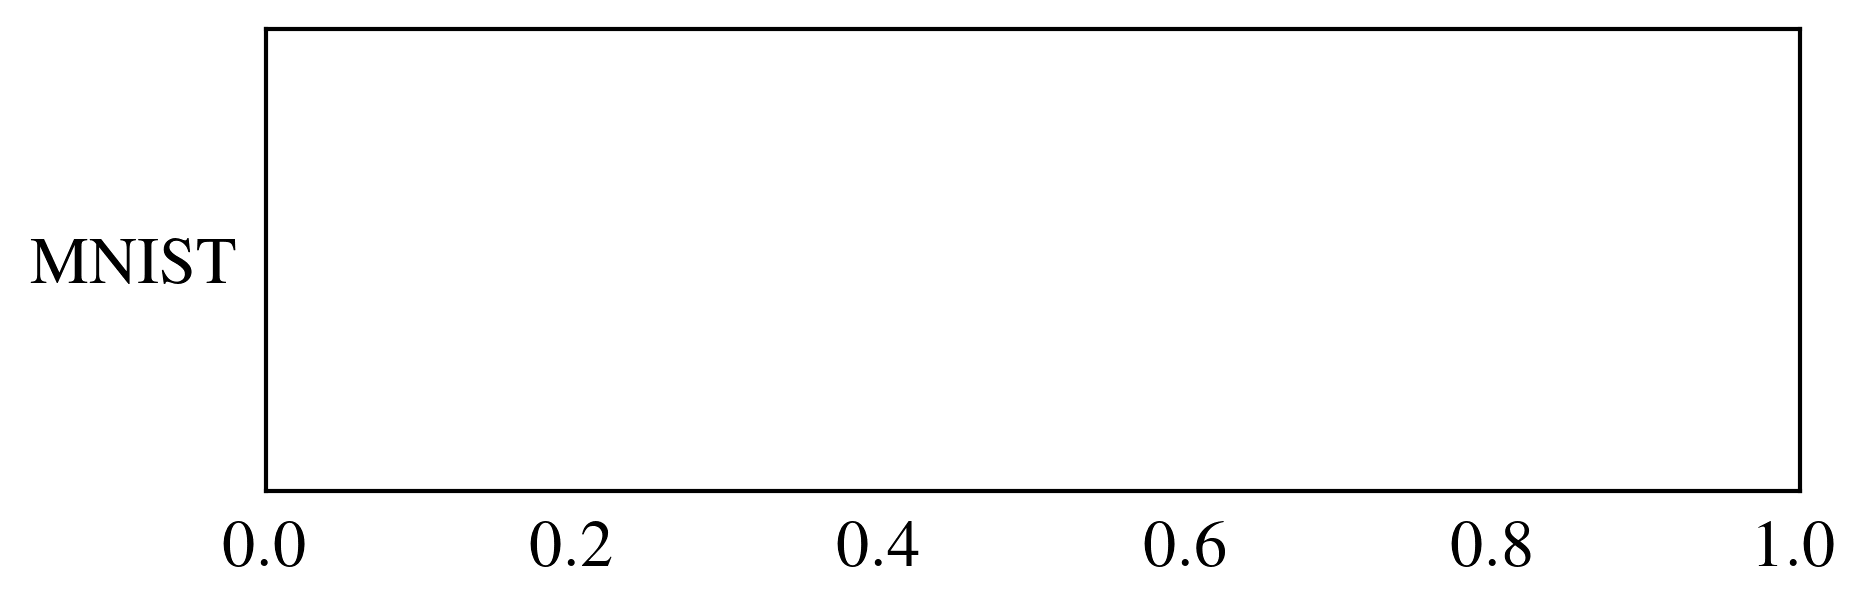

In [ ]:
fig, ax = plt.subplots()

fig.set_figheight(1)

plt.rcParams.update({'ytick.left': False})
plt.rcParams.update({'ytick.right': False})

labels = ['MNIST original task', 'MNIST new task', 'FMNIST original task', 'FMNIST new task']
# certified_values = [certified_accuracy_originial_task,0, certified_accuracy_originial_task_fmnist, 0]
# initial_values = [0,initial_accuracy_new_task, 0, initial_accuracy_new_task_fmnist]
# first_values = [certified_accuracy_originial_task,initial_accuracy_new_task, certified_accuracy_originial_task_fmnist, initial_accuracy_new_task_fmnist]

fine_original = [fine_tuned_accuracy_original_task, 0, fine_tuned_accuracy_original_task_fmnist,0]
fine_original.reverse()

fine_new = [0, fine_tuned_accuracy_new_task, 0, fine_tuned_accuracy_new_task_fmnist]
fine_new.reverse()

fine = [[fine_tuned_accuracy_new_task, fine_tuned_accuracy_original_task], [fine_tuned_accuracy_new_task_fmnist, fine_tuned_accuracy_original_task_fmnist]]
fine.reverse()

certificates = [certified_accuracy_originial_task, 0, certified_accuracy_originial_task_fmnist, 0]
certificates_w = np.array([0,1,0,1])*0.005
certificates.reverse()

# fine_values = [
#     fine_tuned_accuracy_original_task - certified_accuracy_originial_task,
#     fine_tuned_accuracy_new_task-initial_accuracy_new_task, 
#     fine_tuned_accuracy_original_task_fmnist - certified_accuracy_originial_task_fmnist,
#     fine_tuned_accuracy_new_task_fmnist-initial_accuracy_new_task_fmnist, 
# ]
# fine_values.reverse()
# initial_values.reverse()
# certified_values.reverse()
# first_values.reverse()
labels.reverse()

# ax.barh(labels, certified_values, color='#00ad3a', label='Certified model')
# ax.barh(labels, initial_values, color='#ffa000', label='Initial model')
# ax.barh(labels, fine_values, left=first_values,color='#00aaff', label='Fine tuned model')

ax.barh(labels, fine_original, color="#00aaff", label='Fine Tuned Model')
ax.barh(labels, fine_new, color="#00aaff")
ax.barh(labels, certificates_w, left=certificates, color="#000000", height=1)

point = Line2D([0], [0], label='Original Task Certificate', marker='|', markersize=8, 
         color='#000000', linestyle='')

handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([point])



ax.legend(facecolor='#ffffff', framealpha=1, frameon=True, fontsize='x-small', handles=handles, handleheight=1)